In [1]:
!pip install -U git+https://github.com/huggingface/transformers -q

In [2]:
!wget https://d8it4huxumps7.cloudfront.net/files/66e31d6ee96cd_student_resource_3.zip
!unzip 66e31d6ee96cd_student_resource_3.zip
!rm 66e31d6ee96cd_student_resource_3.zip

--2024-09-13 14:35:04--  https://d8it4huxumps7.cloudfront.net/files/66e31d6ee96cd_student_resource_3.zip
Resolving d8it4huxumps7.cloudfront.net (d8it4huxumps7.cloudfront.net)... 18.160.249.41, 18.160.249.9, 18.160.249.126, ...
Connecting to d8it4huxumps7.cloudfront.net (d8it4huxumps7.cloudfront.net)|18.160.249.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5184192 (4.9M) [application/zip]
Saving to: '66e31d6ee96cd_student_resource_3.zip'

66e31d6ee96cd_stude 100%[===================>]   4.94M  --.-KB/s    in 0.1s    

2024-09-13 14:35:04 (50.0 MB/s) - '66e31d6ee96cd_student_resource_3.zip' saved [5184192/5184192]

Archive:  66e31d6ee96cd_student_resource_3.zip
replace __MACOSX/._student_resource 3? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import pandas as pd
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import os

In [4]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

english = {}


for k in entity_unit_map.keys():
    english[k] = k
    
english["item_weight"] = "weight"
english["item_volume"] = "volume"


In [6]:
import csv
import re

# Define mapping from short form to full form
unit_full_form_mapping = {
    'cm': 'centimeter',
    'ft': 'foot',
    'yd': 'yard',
    'm': 'meter',
    'mm': 'millimeter',
    'in': 'inch',
    'g': 'gram',
    'kg': 'kilogram',
    'mg': 'milligram',
    'µg': 'microgram',
    'oz': 'ounce',
    'lb': 'pound',
    't': 'ton',
    'kV': 'kilovolt',
    'V': 'volt',
    'mV': 'millivolt',
    'kW': 'kilowatt',
    'W': 'watt',
    'cL': 'centiliter',
    'L': 'liter',
    'mL': 'milliliter',
    'µL': 'microliter',
    'dL': 'deciliter',
    'cup': 'cup',
    'pt': 'pint',
    'in^3': 'cubic inch',
    'ft^3': 'cubic foot',
    'gal': 'gallon',
    'imp gal': 'imperial gallon',
    'fl oz': 'fluid ounce',
    'qt': 'quart'
}

# Example input text
text_input = [
    "the weight of the product is 15 g",
    "the length of the item is 50 cm",
    "the volume of the liquid is 3 L",
    "the distance is 10 ft",
    "the wattage is 120 W"
]

# Prepare data for CSV
data = []
index = 0

# Regex pattern to extract numeric value and unit from the text
pattern = r'(\d+)\s*([a-zA-Z^3]+)'

# Process each input line
for line in text_input:
    match = re.search(pattern, line)
    if match:
        value, short_unit = match.groups()
        
        # Convert the short unit to its full form
        full_unit = unit_full_form_mapping.get(short_unit, short_unit)  # Default to the same unit if not found
        
        # Create the prediction string
        prediction = f"{value} {full_unit}"
        
        # Append the prediction to the data list
        data.append({"index": index, "prediction": prediction})
        index += 1

# Define the CSV file name
csv_file = "text_input_predictions.csv"

# Write to CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["index", "prediction"])
    writer.writeheader()
    writer.writerows(data)

print(f"CSV file '{csv_file}' created successfully.")
with open('text_input_predictions.csv','r') as file:
    df=file.read()
    print(df)


CSV file 'text_input_predictions.csv' created successfully.
index,prediction
0,15 gram
1,50 centimeter
2,3 liter
3,10 foot
4,120 watt



# Setup

In [5]:
df = pd.read_csv("/kaggle/working/student_resource 3/dataset/test.csv")
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Inference

In [6]:
trans = transforms.Resize((600, 600))
def get_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    resized = trans(img)
    return resized

In [7]:
subset = df[:10]

In [8]:
def url_to_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    resized = trans(img)
    return resized

# Replace the 'image_link' column with PIL.Image objects


In [50]:
def forward(entity_name, image):
    messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": f"What is the {english[entity_name]} of the item"},
        ],
    }
    ]


    
    #text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    text = processor.apply_chat_template(messages, add_generation_prompt=True)

    
    inputs = processor(
        text=[text], 
        images=[image], 
        padding=True, 
        return_tensors="pt"
    )

    inputs = inputs.to("cuda")
    
    
    output_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )

    del inputs
    del generated_ids
    del output_ids
    
    return output_text

In [51]:
subset['image'] = subset['image_link'].apply(url_to_image)

# Test the conversion by checking the first few rows
print(subset.head())


   index                                         image_link  group_id  \
0      0  https://m.media-amazon.com/images/I/110EibNycl...    156839   
1      1  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
2      2  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
3      3  https://m.media-amazon.com/images/I/11TU2clswz...    792578   
4      4  https://m.media-amazon.com/images/I/11gHj8dhhr...    792578   

  entity_name                                              image  
0      height  <PIL.Image.Image image mode=RGB size=600x600 a...  
1       width  <PIL.Image.Image image mode=RGB size=600x600 a...  
2      height  <PIL.Image.Image image mode=RGB size=600x600 a...  
3       depth  <PIL.Image.Image image mode=RGB size=600x600 a...  
4       depth  <PIL.Image.Image image mode=RGB size=600x600 a...  


/tmp/ipykernel_1107/372675671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['image'] = subset['image_link'].apply(url_to_image)


In [52]:
ix = 8
img = subset.loc[ix, "image"]
ename = subset.loc[ix, "entity_name"]

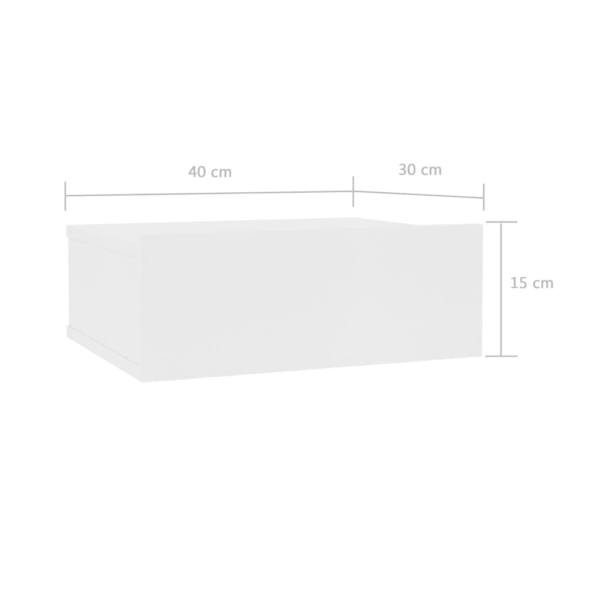

In [53]:
img

In [54]:
forward(ename, img)

['The width which represents the length in the horizontal direction of the item is 15 cm.']

In [55]:
subset

,index,image_link,group_id,entity_name,image
0,0,https://m.media-amazon.com/images/I/110EibNycl...,156839,height,<PIL.Image.Image image mode=RGB size=600x600 a...
1,1,https://m.media-amazon.com/images/I/11TU2clswz...,792578,width,<PIL.Image.Image image mode=RGB size=600x600 a...
2,2,https://m.media-amazon.com/images/I/11TU2clswz...,792578,height,<PIL.Image.Image image mode=RGB size=600x600 a...
3,3,https://m.media-amazon.com/images/I/11TU2clswz...,792578,depth,<PIL.Image.Image image mode=RGB size=600x600 a...
4,4,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,depth,<PIL.Image.Image image mode=RGB size=600x600 a...
5,5,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,height,<PIL.Image.Image image mode=RGB size=600x600 a...
6,6,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,width,<PIL.Image.Image image mode=RGB size=600x600 a...
7,7,https://m.media-amazon.com/images/I/11lshEUmCr...,156839,height,<PIL.Image.Image image mode=RGB size=600x600 a...
8,8,https://m.media-amazon.com/images/I/21+i52HRW4...,478357,width,<PIL.Image.Image image mode=L size=600x600 at ...
9,9,https://m.media-amazon.com/images/I/21-LmSmehZ...,478357,height,<PIL.Image.Image image mode=RGB size=600x600 a...


In [56]:
output = pd.DataFrame({"index": [], "prediction": []})

In [ ]:
for record in subset:
    img = url_to_image(record["image_link"])
    ename = record["entity_name"]
    
    pred = forward(ename, img)
    
    output.iloc[record["index"], "prediction"] = pred
    
    

In [ ]:
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/Kenil-kavar/XYZ.git
git push -u origin main